In [1]:
import numpy as np
import cv2, time
from matplotlib import pyplot as plt
from matplotlib import cm
from JokeFunc import GrayImg, LinSys
from importlib import reload
GrayImg = reload(GrayImg)
LinSys = reload(LinSys)

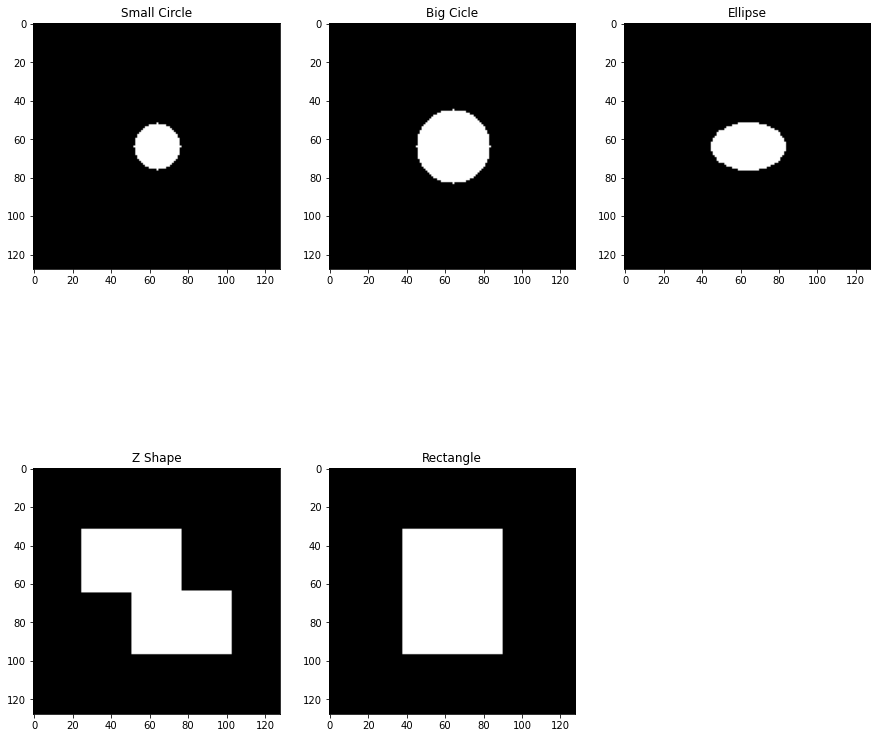

In [2]:
img_shape = (128,128)
height,width = img_shape[0], img_shape[1]
center = (height//2,width//2)

circle_small = cv2.circle(np.zeros(img_shape),center,img_shape[0]//10,255,-1)
circle_big = cv2.circle(np.zeros(img_shape),center,img_shape[0]*3//20,255,-1)
ellipse = cv2.ellipse(np.zeros(img_shape),center,(img_shape[0]*3//20,img_shape[0]//10),0,0,360,255,-1)

Z_shape = cv2.rectangle(np.zeros(img_shape),(width//5,height//4),(3*width//5,height//2),color=(255,255,255),thickness=-1)
Z_shape = cv2.rectangle(Z_shape,(2*width//5,height//2),(4*width//5,3*height//4),color=(255,255,255),thickness=-1)
rectangle = cv2.rectangle(np.zeros(img_shape),(3*width//10,height//4),(7*width//10,3*height//4),color=(255,255,255),thickness=-1)


figure = plt.figure(figsize=(15,15))
figure.add_subplot(2,3,1)
plt.title('Small Circle')
plt.imshow(circle_small,cmap='gray')
figure.add_subplot(2,3,2)
plt.title('Big Cicle')
plt.imshow(circle_big,cmap='gray')
figure.add_subplot(2,3,3)
plt.title('Ellipse')
plt.imshow(ellipse,cmap='gray')
figure.add_subplot(2,3,4)
plt.title('Z Shape')
plt.imshow(Z_shape,cmap='gray')
figure.add_subplot(2,3,5)
plt.title('Rectangle')
plt.imshow(rectangle,cmap='gray')
plt.show()

(170, 170) (170, 170)


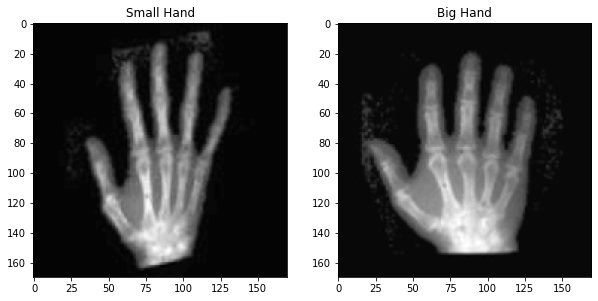

In [3]:
hand_small = cv2.imread(r'C:\Users\Admin\ImageRegistration\Image\R1.png',32)
hand_big = cv2.imread(r'C:\Users\Admin\ImageRegistration\Image\T1.png',32)

#resize images
hand_small = hand_small[:-1,:] 
hand_big = hand_big[:-1,:]

print(hand_small.shape,hand_big.shape)
figure = plt.figure(figsize=(10,10))
figure.add_subplot(1,2,1)
plt.title('Small Hand')
plt.imshow(hand_small,cmap='gray',vmax=255,vmin=0)
figure.add_subplot(1,2,2)
plt.title('Big Hand')
plt.imshow(hand_big,cmap='gray',vmax=255,vmin=0)
plt.show()

In [7]:


ref_img = np.float32(img1)/255
temp_img = np.float32(img3)/255
m,n = ref_img.shape

#common parameters
Imax = 10000
alpha = 1e-3
ssd_eps = 5e-2
res_eps = 5e-2
diff_eps = 1e-4
print_every = 100

In [20]:
#used in 3d plot
X = np.arange(0,m,1)
Y = np.arange(0,n,1)
X, Y = np.meshgrid(X, Y)

def ex_neuBCs(u): #extended u by neuman BCs
    ex_u = np.zeros((2,m+2,n+2))
    ex_u[:,1:-1,1:-1] = u
    ex_u[:,0,1:-1] = u[:,0,:]
    ex_u[:,1:-1,0] = u[:,:,0]
    ex_u[:,-1,1:-1] = u[:,-1,:]
    ex_u[:,1:-1,-1] = u[:,:,-1]
    return ex_u

def lap(ex_u):
    #laplacian (4 bounded sides are deleted)
    return ex_u[:,:-2,1:-1]+ex_u[:,1:-1,:-2]+ex_u[:,2:,1:-1]+ex_u[:,1:-1,2:]-4*ex_u[:,1:-1,1:-1]

def cdiff(ex_Tu):
    Tu_dx = (ex_Tu[2:,1:-1]-ex_Tu[:-2,1:-1])/2 #central
    Tu_dy = (ex_Tu[1:-1,2:]-ex_Tu[1:-1,:-2])/2 #central
    Tu_du = np.zeros((2,m,n))
    Tu_du[0,:,:] = Tu_dx
    Tu_du[1,:,:] = Tu_dy
    return Tu_du

from math import floor, ceil
def bi_ip(shape,coor,v):
    m,n = shape
    i,j = coor
    biip = 0
    if 0<=i and i<=m-1 and 0<=j and j<=n-1:
        ci = ceil(i)
        cj = ceil(j)
        fi = floor(i)
        fj = floor(j)
        if ci==fi:
            dib=1/2
            dif=1/2
        else:
            dib=ci-i
            dif=i-fi
        if cj==fj:
            djb=1/2
            djf=1/2
        else:
            djb=cj-j
            djf=j-fj
        biip = dib*djb*v[ci,cj]+dif*djb*v[fi,cj]+dib*djf*v[ci,fj]+dif*djf*v[fi,fj]
    return biip

def uexp(u,w):
    v = w/2
    N = 1
    while np.max(v)>0.5:
        v/=2
        N+=1
    m,n = w[0].shape
    uexp_w = w.copy()
    for i in range(m):
        for j in range(n):
            i0 = i
            j0 = j
            for k in range(N):
                    i1 = i0 + bi_ip((m,n),(i0,j0),v[0])
                    j1 = j0 + bi_ip((m,n),(i0,j0),v[1])
                    i0 = i1
                    j0 = j1
            i1 = i0 + bi_ip((m,n),(i0,j0),u[0])
            j1 = j0 + bi_ip((m,n),(i0,j0),u[1]) 
            i0 = i1
            j0 = j1
            uexp_w[0,i,j] = i0-i
            uexp_w[1,i,j] = j0-j
    return uexp_w

def show_result(ref_img,regist_Diff_ETM_img,temp_img,grid_warp,vec_field,X,Y,u):
    fig = plt.figure(figsize=(15,15))
    fig.add_subplot(3,3,1)
    plt.title('Reference Image')
    plt.imshow(ref_img,cmap='gray')
    fig.add_subplot(3,3,2)
    plt.title('Registed Image')
    plt.imshow(regist_Diff_ETM_img,cmap='gray')
    fig.add_subplot(3,3,3)
    plt.title('Template Image')
    plt.imshow(temp_img,cmap='gray')
    fig.add_subplot(3,3,4)
    plt.title('Grid warp')
    plt.imshow(grid_warp,cmap='gray')
    fig.add_subplot(3,3,5)
    plt.title('Vector Field')
    plt.imshow(vec_field,cmap='gray')
    fig.add_subplot(3,3,6)
    plt.title('relative SSD - iteration')
    plt.scatter(np.arange(k+1),ssd_list,color="green",marker="*",s=10)
    u_1 = fig.add_subplot(337,projection='3d')
    plt.title('u_1')
    u_1.plot_surface(X, Y, u[0,:,:], cmap=cm.coolwarm,linewidth=0, antialiased=False)
    u_2 = fig.add_subplot(338,projection='3d')
    plt.title('u_2')
    u_2.plot_surface(X, Y, u[1,:,:], cmap=cm.coolwarm,linewidth=0, antialiased=False)
    plt.show()
    return None

	rel_res = 1.0 
	rel_ssd = 1.0
100
	 100 rounds take time = 64.97603487968445
	rel_diff =  0.13082551024562894
	rel_res = 0.9974596323804756 
	rel_ssd = 0.9991270160955606
200
	 100 rounds take time = 66.52654552459717
	rel_diff =  0.11205731785000653
	rel_res = 0.9959230880202937 
	rel_ssd = 0.9985705031769132
300
	 100 rounds take time = 66.92016363143921
	rel_diff =  0.13040493041379198
	rel_res = 0.9945623550375368 
	rel_ssd = 0.9980733548455916
400
	 100 rounds take time = 67.86852431297302
	rel_diff =  0.12535756275078616
	rel_res = 0.9933058275526845 
	rel_ssd = 0.997567444386227
500
	 100 rounds take time = 71.7341160774231
	rel_diff =  0.11586231561275334
	rel_res = 0.9921069176613856 
	rel_ssd = 0.9970664952606235
600
	 100 rounds take time = 69.5681643486023
	rel_diff =  0.10356198698613264
	rel_res = 0.9910616252602319 
	rel_ssd = 0.9965864949570655
700
	 100 rounds take time = 67.59744310379028
	rel_diff =  0.10355935174586196
	rel_res = 0.9901359231122744 
	rel_ssd = 0.99

5900
	 100 rounds take time = 69.78901767730713
	rel_diff =  0.28672968673816357
	rel_res = 0.9774956328273665 
	rel_ssd = 0.9834116788985421
6000
	 100 rounds take time = 69.7018518447876
	rel_diff =  0.27955088750506407
	rel_res = 0.9770962563712811 
	rel_ssd = 0.9832160392133446
6100
	 100 rounds take time = 69.73100566864014
	rel_diff =  0.2782770216205829
	rel_res = 0.976730529241422 
	rel_ssd = 0.9830268683720286
6200
	 100 rounds take time = 74.16823148727417
	rel_diff =  0.287500672734418
	rel_res = 0.9763957354636503 
	rel_ssd = 0.9828520930766805
6300
	 100 rounds take time = 68.70017695426941
	rel_diff =  0.27005787859880026
	rel_res = 0.976057906316365 
	rel_ssd = 0.9826809136598642
6400
	 100 rounds take time = 68.5541205406189
	rel_diff =  0.2662129977802129
	rel_res = 0.9757616864515459 
	rel_ssd = 0.9825059236892147
6500
	 100 rounds take time = 69.37950205802917
	rel_diff =  0.31549017091383785
	rel_res = 0.9745693049445268 
	rel_ssd = 0.9825459173539626
6600
	 100 rou

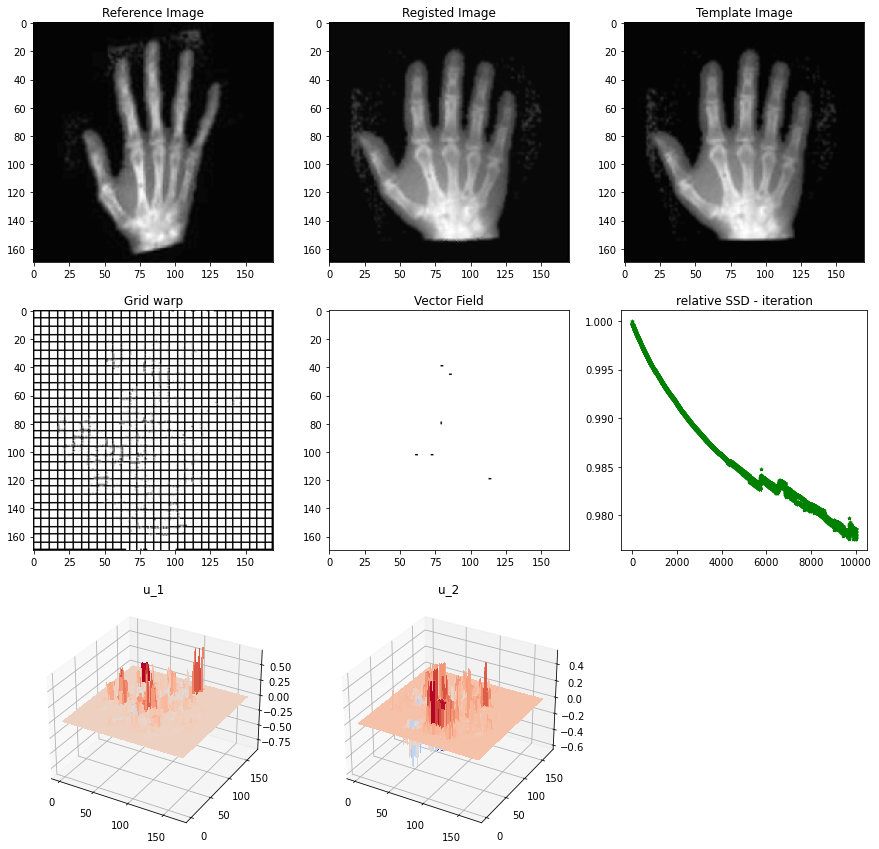

In [63]:
t_start = time.time()
u = np.zeros((2,m,n)) #initial solution
ssd_list = [] #used in relative ssd - iteration plot
res0_exist = False #used to find relative ssd
for k in range(Imax+1):
    u_old = np.copy(u)
    ex_u = ex_neuBCs(u)
    Lp_u = lap(ex_u) #laplacian of u
    ex_Tu = GrayImg.warp_vec(temp_img,ex_u,up=1,left=1,right=1,down=1)
    Tu = ex_Tu[1:-1,1:-1]
    Tu_du = cdiff(ex_Tu) #central approximated
    fu = (Tu-ref_img)*Tu_du        
    
    Res = alpha*Lp_u-fu #residue array
    
    norm_Res = np.linalg.norm(Res)
    ssd = (np.sum((Tu-ref_img)**2))/2
    if not res0_exist:
        res0 = norm_Res
        ssd0 = ssd
        res0_exist = True
    rel_res = norm_Res/res0
    rel_ssd = ssd/ssd0
    ssd_list.append(rel_ssd)
    if k%print_every==0:
        t_loop = time.time()
        print('\trel_res =',rel_res,'\n\trel_ssd =',rel_ssd)
    if rel_res<res_eps or rel_ssd<ssd_eps:
        print('solution converges')
        break
        
    if k<Imax:
        J = -Tu_du
        J2 = np.linalg.norm(J)**2
        w = ((Tu-ref_img)/(J2+alpha))*J
        u = uexp(u,w) #update u
        
        rel_diff = np.linalg.norm(u-u_old)/np.linalg.norm(u)
        if (k+1)%print_every==0:
            print(k+1)
            print('\t',print_every,'rounds take time =',time.time()-t_loop)
            print('\trel_diff = ',rel_diff)
        if rel_diff<diff_eps:
            print('solution dose not change')
            break        
if k==Imax:
    print('Exceed')
regist_Diff_ETM_img = np.clip(Tu,0,1)
grid_array = 1-GrayImg.grid_array((m,n),30,30)
grid_warp = GrayImg.warp_vec(grid_array,u) #bilinear interpolation
vec_field = GrayImg.vec_field_array((m,n),u,30,30)

#show results
print('\n\niteration =',k,'\nrel_diff = ',rel_diff,'\nrel_res =',
      rel_res,'\nrel_ssd =',rel_ssd,'\ntotal_time =',time.time()-t_start)
show_result(ref_img,regist_Diff_ETM_img,temp_img,grid_warp,vec_field,X,Y,u)